## 0 - Introduction

Welcome to the <span style="color:yellowgreen">Foundations of Machine Learning</span> (ECE5984_41) course!

This is the <span style="color:red">3rd</span> lab practice. From now on, you will going to implement Softmax regression, MLP

## 1. Packages 

You have to install and use below packages for HW#2.
- [numpy](https://www.numpy.org): Fundamental package for matrix computation with python.
- [matplotlib](https://matplotlib.org): Package for visualization of the graph with python.
- [scikit-learn](https://scikit-learn.org/stable/):  Python module for machine learning built on top of SciPy

**Do not use other machine learning packages in this homework, e.g., *tensorflow*, *pytorch*, *jax*, etc.**

In [735]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import sklearn.datasets as skdatasets
from sklearn.model_selection import train_test_split

# 2. Softmax regression (multi-class classification)

### 2.1. Load dataset

In [736]:
def load_iris(normalize):
    # import data
    X, y = skdatasets.load_iris(return_X_y=True)
    # only use 1st & 3rd features
    X = X[:, [0, 2]]
    if normalize:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_iris(X, y, x1_mesh=None, x2_mesh=None, y_mesh=None):
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(10, 6))
    plt.scatter(x1[y==0], x2[y==0], c='tab:blue', marker='o', label='Setosa')
    plt.scatter(x1[y==1], x2[y==1], c='tab:orange', marker='^', label='Versicolour')
    plt.scatter(x1[y==2], x2[y==2], c='tab:green', marker='x', label='Virginica')
    if x1_mesh is not None:
        cmap = mplcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])
        plt.contourf(x1_mesh, x2_mesh, y_mesh, levels=3, cmap=cmap, alpha=0.3)
    plt.title('Softmax Regression (Iris dataset)', fontsize=18, pad=12)
    plt.xlabel('x1: Sepal length', fontsize=16, labelpad=12) # 1st feat
    plt.ylabel('x2: Petal length', fontsize=16, labelpad=12) # 3rd feat
    plt.legend(fontsize=14, loc='upper left')
    plt.show()

In [737]:
x_train, x_test, y_train, y_test = load_iris(normalize=True)

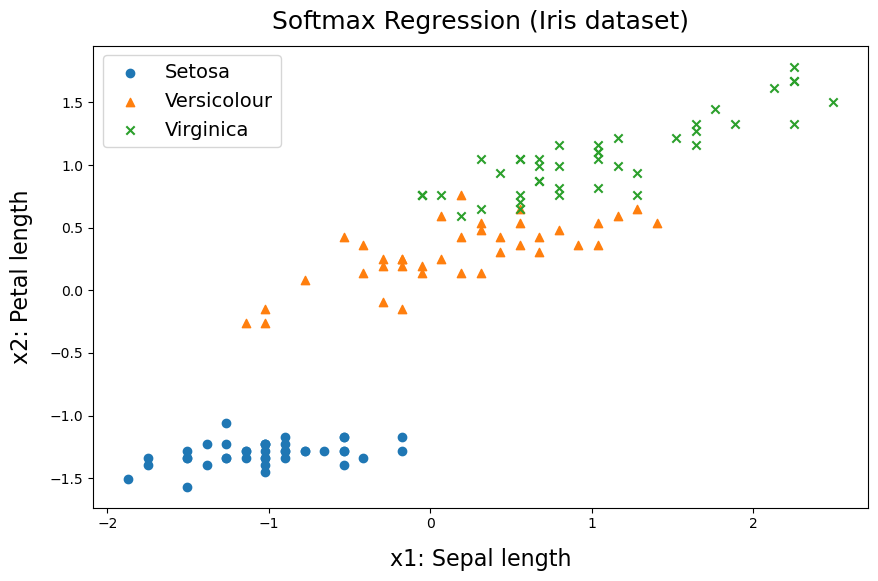

In [738]:
plot_iris(x_train, y_train)

### 2.2. Affine, softmax, cross_entropy

In [739]:
def affine(x, w, b):
    out = None
    #########################################################################
    # TODO: Implement the affine transformation. Store the result in the    #
    # out variable.                                                         #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    out = np.dot(x, w) + b
    
    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    x, w, b = cache
    dx, dw, db = None, None, None
    #########################################################################
    # TODO: Implement the backward pass of the affine transformation.       #
    # Compute the gradient w.r.t inputs, weights, and biases. Store each of #
    # them in the dx, dw, db variable.                                      #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    dw = np.dot(x.T, dout)
    db = np.sum(dout, axis=0)
    dx = np.dot(dout, w.T)
    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    return dx, dw, db

def softmax(x):
    yhat = None
    #########################################################################
    # TODO: Implement the softmax function without using explicit loops.    #
    # Store the softmax scores in the yhat variable.                        #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    x = x - np.max(x, axis=1)[:, None]
    yhat = np.exp(x) / np.sum(np.exp(x), axis=1)[:, None]
    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    return yhat

def one_hot(x, n_class):
	return np.eye(n_class)[x]

def cross_entropy_loss(yhat, y, n_class):
    # clip values to prevent divide by zero
    yhat = np.clip(yhat, a_min=1e-7, a_max=1-1e-7)

    loss = None
    #########################################################################
    # TODO: Implement the cross-entropy function. Store the cross-entropy   #
    # loss in the loss variable. Note that the yhat is the output of the    #
    # softmax function implemented above.                                   #
    #########################################################################
    # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    loss = -np.mean(np.sum(np.log(yhat) * one_hot(y, n_class), axis=1))
    # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
    
    return loss

def cross_entropy_loss_and_grad(x, y, n_class):
    yhat = softmax(x)
    loss = cross_entropy_loss(yhat, y, n_class)
    grad = yhat - one_hot(y, n_class)
    return loss, grad

### 2.3. Train model

In [740]:
def train_softmax_regression(x_train, x_test, y_train, y_test, lr, epochs, log_every):
    # set seed
    np.random.seed(444)
    # shape
    _, in_features = x_train.shape
    out_features = len(np.unique(y_train))
    # initialize weights
    w = np.random.rand(in_features, out_features)
    b = np.zeros(out_features)
    # begin training
    for e in range(1, epochs+1):
        # forward affine (out = wx + b)
        out, cache = affine(x_train, w, b)
        # compute cross-entropy loss and grad (dL/dout)
        loss, dout = cross_entropy_loss_and_grad(out, y_train, out_features)
        # backward affine
        _, dw, db = affine_backward(dout, cache)
        # gradient descent
        w -= lr * dw
        b -= lr * db
        # print log
        if e % log_every == 0:
            yhat = softmax(affine(x_test, w, b)[0])
            accr = np.mean(np.argmax(yhat, axis=1) == y_test)
            loss = cross_entropy_loss(yhat, y_test, out_features)
            print(f'Epochs: {e}/{epochs}, loss (test): {loss:.4f}, accuracy (test): {accr:.4f}')
    return w, b

In [741]:
w, b = train_softmax_regression(x_train, x_test, y_train, y_test, lr=1e-2, epochs=200, log_every=20)

Epochs: 20/200, loss (test): 0.4887, accuracy (test): 0.7333
Epochs: 40/200, loss (test): 0.4218, accuracy (test): 0.7333
Epochs: 60/200, loss (test): 0.3778, accuracy (test): 0.7667
Epochs: 80/200, loss (test): 0.3453, accuracy (test): 0.8000
Epochs: 100/200, loss (test): 0.3205, accuracy (test): 0.8333
Epochs: 120/200, loss (test): 0.3012, accuracy (test): 0.8667
Epochs: 140/200, loss (test): 0.2858, accuracy (test): 0.8667
Epochs: 160/200, loss (test): 0.2734, accuracy (test): 0.8667
Epochs: 180/200, loss (test): 0.2632, accuracy (test): 0.8667
Epochs: 200/200, loss (test): 0.2546, accuracy (test): 0.9000


In [742]:
def compute_decision_boundary(x, w, b, resolution):
    x1, x2 = x[:, 0], x[:, 1]
    x1_mesh = np.linspace(np.min(x1) - 0.1, np.max(x1) + 0.1, resolution)
    x2_mesh = np.linspace(np.min(x2) - 0.1, np.max(x2) + 0.1, resolution)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh, indexing='xy')
    x = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    y_mesh = np.argmax(softmax(affine(x, w, b)[0]), axis=1)
    y_mesh = y_mesh.reshape(resolution, resolution)
    return x1_mesh, x2_mesh, y_mesh

In [743]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary(x_test, w, b, resolution=500)

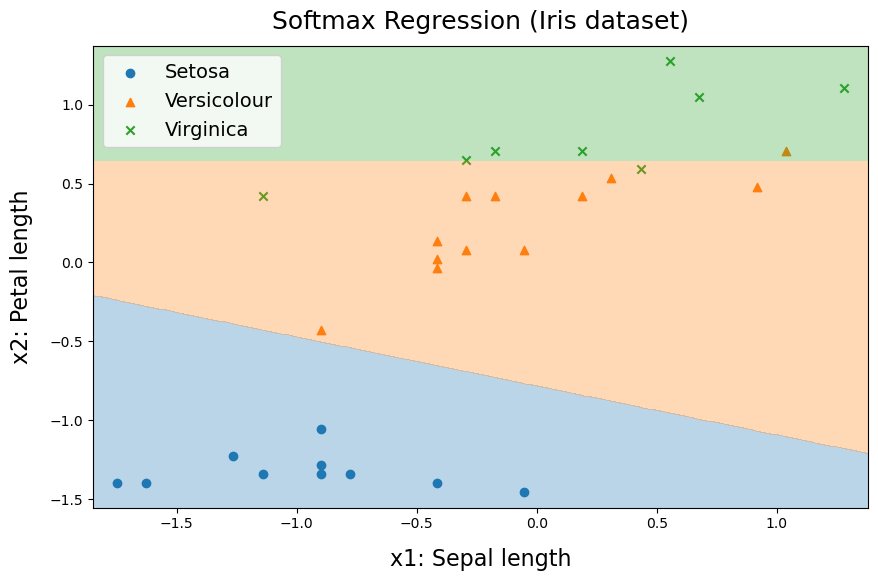

In [744]:
plot_iris(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

# 3. Multi-layer perceptron (MLP)

### 3.1. Generate dataset (linearly non-separable)

In [745]:
# from cs231n
# https://cs231n.github.io/neural-networks-case-study/
def generate_spiral_data(n_points, n_features, n_classes):
    np.random.seed(444)
    X = np.zeros((n_points*n_classes, n_features))
    y = np.zeros((n_points*n_classes,), dtype=np.uint8)
    for j in range(n_classes):
        i = range(n_points*j, n_points*(j+1))
        r = np.linspace(0., 1, n_points) # radius
        t = np.linspace(j*4, (j+1)*4, n_points) + np.random.randn(n_points) * 0.2 # theta
        X[i] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[i] = j
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_spiral(X, y, x1_mesh=None, x2_mesh=None, x3_mesh=None):
    x1, x2 = X[:, 0], X[:, 1]
    plt.figure(figsize=(10, 6))
    plt.scatter(x1[y==0], x2[y==0], c='tab:blue', marker='o', label='class:0')
    plt.scatter(x1[y==1], x2[y==1], c='tab:orange', marker='^', label='class:1')
    plt.scatter(x1[y==2], x2[y==2], c='tab:green', marker='x', label='class:2')
    if x1_mesh is not None:
        cmap = mplcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])
        plt.contourf(x1_mesh, x2_mesh, y_mesh, levels=3, cmap=cmap, alpha=0.3)
    plt.title('MLP (Spiral dataset)', fontsize=18, pad=12)
    plt.xlabel('x1', fontsize=16, labelpad=12)
    plt.ylabel('x2', fontsize=16, labelpad=12)
    plt.legend(fontsize=14, loc='upper left')
    plt.show()

In [746]:
x_train, x_test, y_train, y_test = generate_spiral_data(n_points=100, n_features=2, n_classes=3)

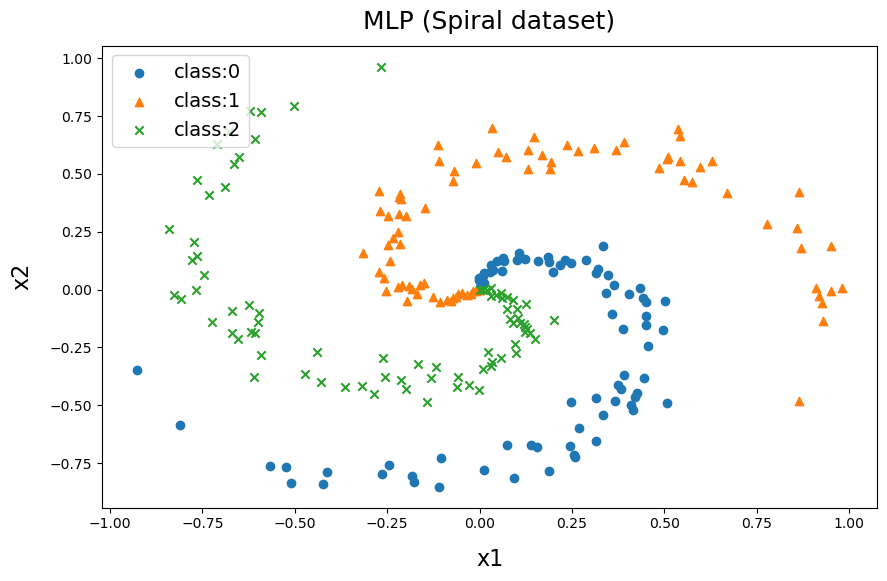

In [747]:
plot_spiral(x_train, y_train)

### 3.2. MLP implementation

* **Q1** (Linear layer): 4 points; 1 point each

In [748]:
class Linear:
    def __init__(self, in_features, out_features, is_first=False):
        #########################################################################
        # TODO: Initialize the weights and biases of the linear layer. Store    #
        # the weights in the self.w variable and biases in the self.b variable. #
        # Weights should be a 2d np.ndarray of shape (in_features, out_features)#
        # and initialized from a Uniform ranged [0, 1]. Biases should be a 1d   #
        # np.ndarray of shape (out_features,) and initialized to zero.          #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        self.w = np.random.randn(in_features, out_features)
        self.b = np.zeros(out_features,)
        
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        self.dw = None
        self.db = None
        self.is_first = is_first
    
    def __call__(self, x):
        out = None
        self.input = x # cache for backward
        #########################################################################
        # TODO: Implement the forward pass for the linear layer. Compute the    #
        # affine transform of X and store the result in the out variable.       #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        # affine transform: y = wx + b 
        out = np.dot(x, self.w) + self.b

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return out
    
    def backward(self, dout):
        #########################################################################
        # TODO: Implement the backward pass for the linear layer. Store the     #
        # gradient of loss w.r.t weights (dL/dw) in the self.dw variable, and   #
        # the gradient of loss w.r.t biases (dL/db) in the self.db variable.    #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        # https://www.youtube.com/watch?v=pauPCy_s0Ok&t=1144s
        # https://github.com/TheIndependentCode/Neural-Network
        
        # dout == grad = yhat - one_hot(y, self.n_class)
        self.dw = np.dot(self.input.T, dout)  
        self.db = np.sum(dout, axis=0, keepdims=True)  

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

        dx = None
        ########################################################    #################
        # TODO: Implement the backward pass for the linear layer. Store the     #
        # gradient of loss w.r.t inputs (dL/dx) in the dx variable. Note that   #
        # we compute dx, if this is not the first layer (i.e., if self.is_first #
        # is False)                                                             #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
    
        if not self.is_first:
            dx = np.dot(dout, self.w.T)
        
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

        return dx

* **Q2** (ReLU layer): 2 points; 1 point each

In [749]:
class ReLU:
    def __call__(self, x):
        self.input = x # cache for backward

        out = None
        #########################################################################
        # TODO: Implement the forward pass of ReLU layer. Store the computed    #
        # values in the out variable                                            #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        out = x * (x > 0)
        
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return out
    
    def backward(self, dout):
        dx = None
        #########################################################################
        # TODO: Implement the backward pass of ReLU layer. Store the computed   #
        # values in the dx variable. Note that you can use self.input to        #
        # compute the gradients.                                                #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #

        dx = dout * (self.input > 0) 
 
        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return dx

* MLP (no need to implement)

In [750]:
class MLP:
    def __init__(self, features):
        def setup_layers(features):
            layers = [] # n: in_features, m: out_features
            for i, (n, m) in enumerate(zip(features[:-1], features[1:])):
                layers += [Linear(n, m, i==0), ReLU()]
            del layers[-1]
            return layers
        
        self.layers = setup_layers(features)
    
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

* **Q3** (Cross-entropy layer): 2 points

In [751]:
class CrossEntropyLoss:
    def __init__(self, n_class):
        self.n_class = n_class
    
    def __call__(self, x, y):
        loss, grad = None, None
        #########################################################################
        # TODO: Compute the cross-entropy loss and its gradient without using   #
        # explicit loops. Store the loss in loss variable and the gradient in   #
        # grad variable. Please use the softmax and cross_entropy_loss function #
        # implemented above. Hint: this function is equivalent to the           #
        # cross_entropy_loss_and_grad() implemented above.                      #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        # softmax -> cross_entropy_loss -> grad
        yhat = softmax(x)
        loss = cross_entropy_loss(yhat, y, self.n_class)
        grad = yhat - one_hot(y, self.n_class)

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #
        return loss, grad

* **Q4** (Gradient descent): 2 points

In [752]:
class GradientDescent:
    def __init__(self, layers, lr):
        self.layers = layers
        self.lr = lr

    def step(self):
        #########################################################################
        # TODO: Implement the gradient descent algorithm. Note that self.layers #
        # is a list of layers, where each of them could be either Linear or     # 
        # ReLU. Since a ReLU layer doesn't have learnable parameters, we only   #
        # update the parameters of the Linear layers. Loop through self.layers  #
        # and update the parameters if the layer is instance of Linear class.   #
        #########################################################################
        # ******** START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ******** #
        
        # updating weight and bias for layer
        for layer in self.layers:
            
            if isinstance(layer, Linear):
                layer.w = layer.w - self.lr * layer.dw
                layer.b = layer.b - self.lr * layer.db

        # ********* END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE) ********* #

* main function (no need to implement)

In [753]:
def train_mlp(x_train, x_test, y_train, y_test, features, lr, epochs, log_every):
    # set seed
    np.random.seed(444)

    # make a single linear layer
    model = MLP(features)

    # make optimizer
    optim = GradientDescent(model.layers, lr)

    # loss function
    n_class = len(np.unique(y_train))
    loss_fn = CrossEntropyLoss(n_class)

    # evaluation function
    eval_fn = lambda yhat, y: np.mean(np.argmax(yhat, axis=1) == y)

    # begin training
    for e in range(1, epochs+1):
        # forward (linear layer)
        out = model(x_train)
        # compute cross-entropy loss and gradient w.r.t out
        loss, dout = loss_fn(out, y_train)
        # backward (linear layer)
        model.backward(dout)
        # gradient descent
        optim.step()
        # print log
        if e % log_every == 0:
            yhat = softmax(model(x_test))
            loss = cross_entropy_loss(yhat, y_test, n_class)
            accr = eval_fn(yhat, y_test)
            print(f'Epochs: {e}/{epochs}, loss (test): {loss:.4f}, accuracy (test): {accr:.4f}')
    
    return model

def compute_decision_boundary_mlp(x, model, resolution):
    x1, x2 = x[:, 0], x[:, 1]
    x1_mesh = np.linspace(np.min(x1) - 0.1, np.max(x1) + 0.1, resolution)
    x2_mesh = np.linspace(np.min(x2) - 0.1, np.max(x2) + 0.1, resolution)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh, indexing='xy')
    x = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    y_mesh = np.argmax(softmax(model(x)), axis=1).reshape(resolution, resolution)
    return x1_mesh, x2_mesh, y_mesh

### 3.3. Train single layer perceptron

In [754]:
slp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 3], lr=1e-2, epochs=200, log_every=20)

Epochs: 20/200, loss (test): 0.7972, accuracy (test): 0.5333
Epochs: 40/200, loss (test): 0.7777, accuracy (test): 0.5500
Epochs: 60/200, loss (test): 0.7758, accuracy (test): 0.5500
Epochs: 80/200, loss (test): 0.7758, accuracy (test): 0.5500
Epochs: 100/200, loss (test): 0.7761, accuracy (test): 0.5500
Epochs: 120/200, loss (test): 0.7763, accuracy (test): 0.5500
Epochs: 140/200, loss (test): 0.7764, accuracy (test): 0.5500
Epochs: 160/200, loss (test): 0.7765, accuracy (test): 0.5500
Epochs: 180/200, loss (test): 0.7766, accuracy (test): 0.5500
Epochs: 200/200, loss (test): 0.7766, accuracy (test): 0.5500


In [755]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, slp, resolution=500)

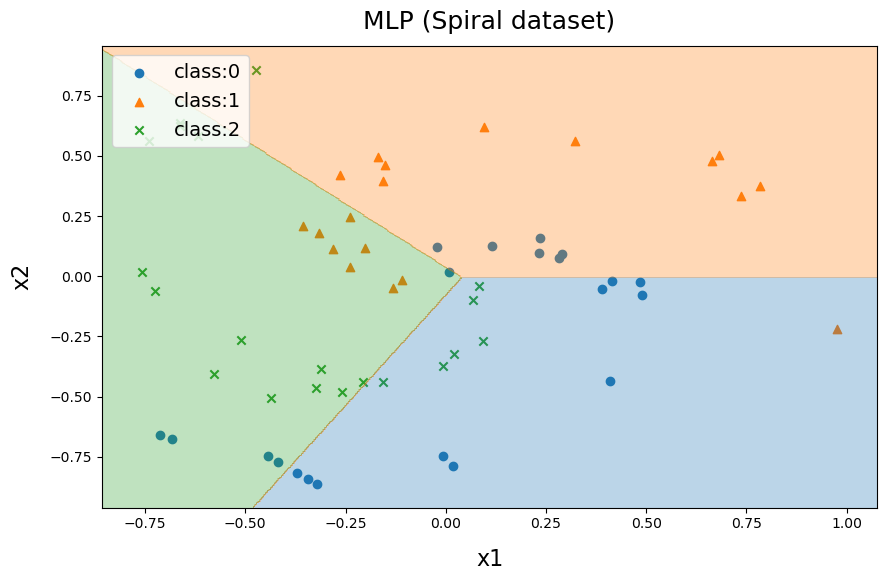

In [756]:
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

### 3.4. Train multi layer perceptron

In [757]:
mlp = train_mlp(x_train, x_test, y_train, y_test, features=[2, 10, 3], lr=1e-2, epochs=500, log_every=50)

Epochs: 50/500, loss (test): 0.4367, accuracy (test): 0.8333
Epochs: 100/500, loss (test): 0.2139, accuracy (test): 0.9667
Epochs: 150/500, loss (test): 0.1669, accuracy (test): 0.9167
Epochs: 200/500, loss (test): 0.1478, accuracy (test): 0.9500
Epochs: 250/500, loss (test): 0.1723, accuracy (test): 0.9167
Epochs: 300/500, loss (test): 0.1105, accuracy (test): 0.9667
Epochs: 350/500, loss (test): 0.0999, accuracy (test): 0.9667
Epochs: 400/500, loss (test): 0.0885, accuracy (test): 0.9667
Epochs: 450/500, loss (test): 0.0787, accuracy (test): 0.9667
Epochs: 500/500, loss (test): 0.0792, accuracy (test): 0.9667


In [758]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary_mlp(x_test, mlp, resolution=500)

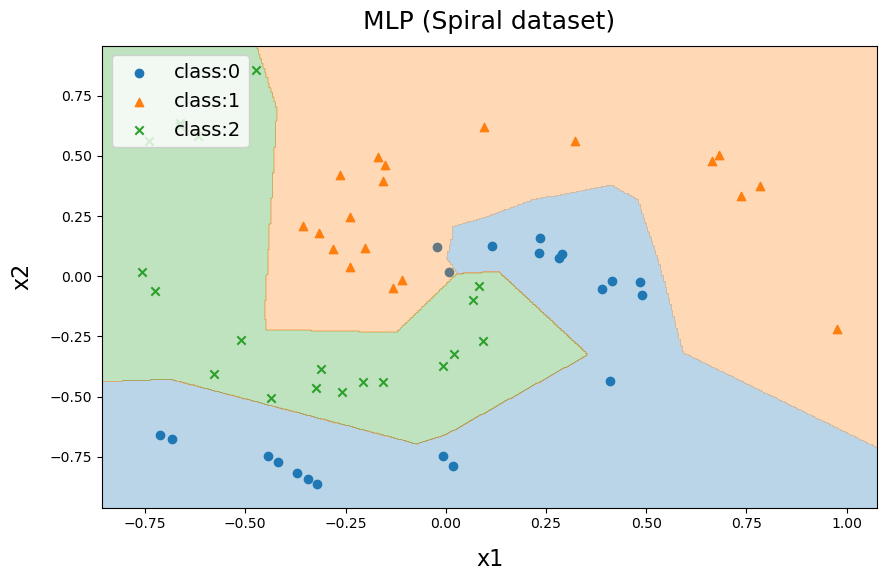

In [759]:
plot_spiral(x_test, y_test, x1_mesh, x2_mesh, y_mesh)

# 4. Optional readings

*   [Neural Networks, Manifolds, and Topology](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/)